In [1]:
import sys
print(sys.path) 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

['/data/cellardata2/users/mpagadal/projects/germline-immune/disease-relevance/notebooks', '/nrnb/opt/anaconda3.7/lib/python37.zip', '/nrnb/opt/anaconda3.7/lib/python3.7', '/nrnb/opt/anaconda3.7/lib/python3.7/lib-dynload', '', '/cellar/users/mpagadal/.local/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/extensions', '/cellar/users/mpagadal/.ipython']


In [2]:
import pandas as pd
import os
import numpy as np
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [3]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get UKBB results

In [14]:
plato=pd.read_csv("/cellar/users/hik010/Data/plato/meghana_tcga/new_results/plato_lev1_lev1_results.txt",delimiter="\t")

In [7]:
icd=pd.read_csv("/cellar/users/hik010/Data/plato/icd_groups.txt",delimiter="\t")
print(icd.shape)
icd.head()

(263, 9)


,code,description,node_id,parent_id,selectable,letter,start,end,list
0,A00-A09,A00-A09 Intestinal infectious diseases,23,1,N,A,A00,A09,"A00,A01,A02,A03,A04,A05,A06,A07,A08,A09"
1,A15-A19,A15-A19 Tuberculosis,24,1,N,A,A15,A19,"A15,A16,A17,A18,A19"
2,A20-A28,A20-A28 Certain zoonotic bacterial diseases,25,1,N,A,A20,A28,"A20,A21,A22,A23,A24,A25,A26,A27,A28"
3,A30-A49,A30-A49 Other bacterial diseases,26,1,N,A,A30,A49,"A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,A4..."
4,A50-A64,A50-A64 Infections with a predominantly sexual...,27,1,N,A,A50,A64,"A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A6..."


In [17]:
mp_dict=dict(zip(icd["code"],icd["description"]))

In [18]:
plato["description"]=plato["Outcome"].map(mp_dict)

In [19]:
plato.head()

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_Missing,Analysis_Type,Converged,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval,Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,description
0,K90-K93,rs3134977,6:32651641,G:0.853664,104690,logistic,1,0.0,0.740121,0.015419,0.0,0.0,0.0,K90-K93 Other diseases of the digestive system
1,K90-K93,rs9274514,6:32634243,G:0.746485,104883,logistic,1,0.0,0.782754,0.013088,0.0,0.0,0.0,K90-K93 Other diseases of the digestive system
2,L40-L45,rs3931670,6:31243767,G:0.750672,104834,logistic,1,0.0,0.640474,0.026420,0.0,0.0,0.0,L40-L45 Papulosquamous disorders
3,L40-L45,rs2040748,6:31243785,G:0.788525,104805,logistic,1,0.0,0.618117,0.027289,0.0,0.0,0.0,L40-L45 Papulosquamous disorders
4,L40-L45,rs2905725,6:31458936,A:0.959599,105095,logistic,1,0.0,0.423374,0.043798,0.0,0.0,0.0,L40-L45 Papulosquamous disorders


In [20]:
len(plato["Var1_ID"].unique())

520

In [21]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


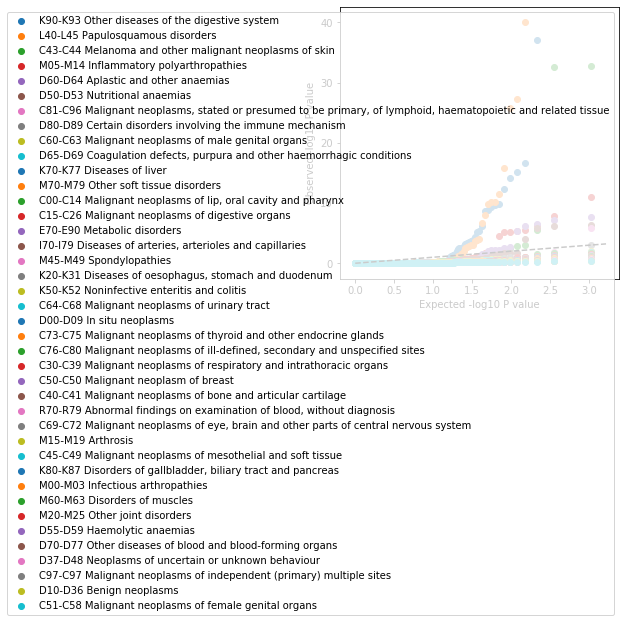

In [22]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for x in plato["description"].unique():
    plato_disease=plato[plato["description"]==x]
    p_values=plato_disease.sort_values(by="Overall_Pval_adj_FDR")["Overall_Pval_adj_FDR"].tolist()
    plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values),label=x)
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
plt.legend()
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.savefig("../plots/ukbb.pdf")

## Mendelian Randomization 

In [23]:
ukbb_snps=plato[plato["Overall_Pval_adj_FDR"]<.05]
print(ukbb_snps.shape)
ukbb_snps.head()

(114, 14)


,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_Missing,Analysis_Type,Converged,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval,Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,description
0,K90-K93,rs3134977,6:32651641,G:0.853664,104690,logistic,1,0.0,0.740121,0.015419,0.0,0.0,0.0,K90-K93 Other diseases of the digestive system
1,K90-K93,rs9274514,6:32634243,G:0.746485,104883,logistic,1,0.0,0.782754,0.013088,0.0,0.0,0.0,K90-K93 Other diseases of the digestive system
2,L40-L45,rs3931670,6:31243767,G:0.750672,104834,logistic,1,0.0,0.640474,0.026420,0.0,0.0,0.0,L40-L45 Papulosquamous disorders
3,L40-L45,rs2040748,6:31243785,G:0.788525,104805,logistic,1,0.0,0.618117,0.027289,0.0,0.0,0.0,L40-L45 Papulosquamous disorders
4,L40-L45,rs2905725,6:31458936,A:0.959599,105095,logistic,1,0.0,0.423374,0.043798,0.0,0.0,0.0,L40-L45 Papulosquamous disorders


In [24]:
ukbb_snps["description"].value_counts()

K90-K93 Other diseases of the digestive system                                                                   30
L40-L45 Papulosquamous disorders                                                                                 24
M05-M14 Inflammatory polyarthropathies                                                                           13
D60-D64 Aplastic and other anaemias                                                                              13
C43-C44 Melanoma and other malignant neoplasms of skin                                                           10
D50-D53 Nutritional anaemias                                                                                      9
C00-C14 Malignant neoplasms of lip, oral cavity and pharynx                                                       3
C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue     2
D65-D69 Coagulation defects, purpura and other haemorrhagic conditions  

In [25]:
nonhla_snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
hla_snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",delimiter="\t")


In [26]:
rsid_mapping=nonhla_snps[["rsid","file"]].append(hla_snps[["rsid","file"]])

In [27]:
pheno_mapping=rsid_mapping[rsid_mapping["rsid"].isin(ukbb_snps["Var1_ID"].tolist())]

In [28]:

G=nx.Graph()

for i,row in ukbb_snps.iterrows():
    G.add_edge(row["Var1_ID"],row["description"])
for i,row in pheno_mapping.iterrows():
    G.add_edge(row["rsid"],row["file"])

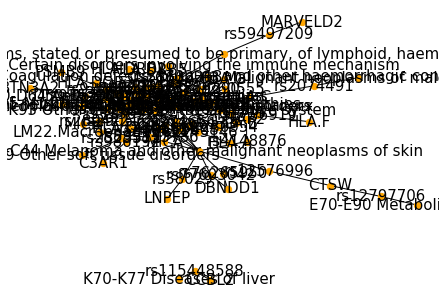

In [29]:
nx.draw(G, with_labels=True, node_color='orange', node_size=40, font_size=15)

In [30]:
final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

Generating CX


'http://public.ndexbio.org/v2/network/2f32b574-3e20-11eb-9e72-0ac135e8bacf'

In [31]:
node=[]
degree=[]
color=[]

for x in G.nodes():
    node.append(x)
    degree.append(len([x for x in G.neighbors(x)]))
    if "rs" in x:
        color.append("red")
    elif "-" in x :
        color.append("purple")
    else:
        color.append("blue")
        

In [32]:
df=pd.DataFrame({"node":node,"degree":degree,"color":color})

In [33]:
df.to_csv("ukbb.network.nodes.csv",index=None)